In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

import warnings
warnings.filterwarnings("ignore")

In [5]:
total_df = pd.read_csv('full_df_week.csv')\
    .rename(columns={'Unnamed: 0':'Date','Price':'actual_return','pred':'predicted_return','lower':'lower_ci','upper':'upper_ci'})\
    .set_index(total_df.Date)

In [6]:
total_df

,Date,actual_return,lower_ci,predicted_return,upper_ci,prob_of_growth,ticker
Date,,,,,,,
2019-07-15,2019-07-15,-0.011875,-0.059085,0.005515,0.070115,0.589508,ЛУКОЙЛ
2019-07-22,2019-07-22,-0.024132,-0.058400,0.006138,0.070676,0.595090,ЛУКОЙЛ
2019-07-29,2019-07-29,0.010837,-0.056551,0.007978,0.072507,0.616258,ЛУКОЙЛ
2019-08-05,2019-08-05,0.030604,-0.058082,0.006395,0.070872,0.599933,ЛУКОЙЛ
2019-08-12,2019-08-12,-0.054284,-0.062263,0.002174,0.066611,0.548002,ЛУКОЙЛ
...,...,...,...,...,...,...,...
2023-07-31,2023-07-31,-0.007615,-0.190236,-0.032234,0.125768,0.344633,FIXP-гдр
2023-08-07,2023-08-07,0.014388,-0.168865,-0.011458,0.145949,0.443276,FIXP-гдр
2023-08-14,2023-08-14,-0.012530,-0.168699,-0.011871,0.144957,0.441029,FIXP-гдр


# Торговый алгоритм

In [46]:
trading_days = total_df.index.unique() #Набор торговых дней с предсказаниями и фактами
bank = 1000 #Сумма денег на моём счету , которые я вкладываю . Это не накопленная стоимость портфеля 
portfolio = {} #Ключ - актив , значение - накопленный по нему доход
grow_hit = 0 #Подсчёт попаданий на росте
fall_hit = 0 #Подсчёт попаданий на падении
grow_miss = 0 #Подсчёт промахов и на росте и на падении
fall_miss = 0
grow_hit_list = [] 
fall_hit_list = [] 
grow_miss_list = [] 
fall_miss_list = []
fall_miss_ratio = []
capital = [] #Сумма денег в портфеле и банке которую в корце визуализирую

In [47]:
for day in trading_days:
    #Устанавливаем активы , которые вносим в списки потенциального роста и потенциального падения
    #good_assets = total_df.loc[day].query('prob_of_growth > 0.7').ticker.values
    #bad_assets = total_df.loc[day].query('prob_of_growth < 0.3').ticker.values
    good_assets = total_df.loc[(total_df.prob_of_growth > 0.7) & (total_df.index == day)].ticker.values
    bad_assets = total_df.loc[(total_df.prob_of_growth < 0.3) & (total_df.index == day)].ticker.values
    
    
    #Продаём все активы перед началом торгового дня
    for asset in list(portfolio):
        bank+=portfolio[asset]
        del portfolio[asset]

    #Продаём активы из зоны падения и возвращаем полученные деньги в банк
    for asset in bad_assets: 
        if asset in list(portfolio):
            bank+=portfolio[asset]
            del portfolio[asset]
        #Проверяем угадали ли направление
        if 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):#1+реальная доходность
            fall_hit+=1
        elif 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
            fall_miss+=1
    
    
    #Определяем разер вложений.
    if len(good_assets) != 0 :
        invest_ammout = bank/len(good_assets)#вкладываем весь банк равномерно
    else : 
        invest_ammout = 0
    #Покупаем активы из зоны роста
    for asset in good_assets: 
        if asset not in list(portfolio): #Если его нет в портфеле ,то добавляем его
            portfolio[asset] = (invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][1])#(1+real_ret)
            bank -= invest_ammout
            #Проверка угадано ли направление доходности
            if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
                grow_hit+=1
            elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
                grow_miss+=1
        #elif asset in list(portfolio): #Если такой актив уже есть
            #portfolio[asset] += invest_ammout #Прибавляем к уже имеющимся вложениям а затем умножем на 1+real return
            #portfolio[asset] = portfolio[asset] * (1 + total_df.loc[total_df.ticker == asset].loc[day][0])
            #bank -= invest_ammout
            #Проверка угадано ли направление доходности
            #if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                #grow_hit+=1
            #elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                #miss+=1 
        
        print(f"В актив { asset } вложил { invest_ammout } и получил {(invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][1])}")    
        
#Пополняю списки попаданий и промахов в конце каждого дня
    grow_hit_list.append(grow_hit)
    fall_hit_list.append(fall_hit)
    grow_miss_list.append(grow_miss)
    fall_miss_list.append(fall_miss)
    if grow_miss+fall_miss != 0:
        fall_miss_ratio.append( (grow_hit+fall_hit)/(grow_miss+fall_miss) ) 
    capital.append( bank+(sum(portfolio[x] for x in portfolio)) )
#____________________ИНФОРМАЦИОННОЕ ОКНО_____________________   
    if len(list(portfolio)) == 0 :
        print(f"В день {day} ничего не покупалось")
    print(f"Банк {bank}")
    print(f"Портфель на момент {day} : {list(portfolio)}")
    print(f"Накопленная доходность портфеля : {sum(portfolio[x] for x in portfolio)}")
    print(f"Угаданных направлений: {grow_hit+fall_hit}")
    print(f"Неугаданных направлений: {fall_miss+grow_miss}")
    print('___________________________\n')

В день 2019-07-15 ничего не покупалось
Банк 1000
Портфель на момент 2019-07-15 : []
Накопленная доходность портфеля : 0
Угаданных направлений: 0
Неугаданных направлений: 0
___________________________

В день 2019-07-22 ничего не покупалось
Банк 1000
Портфель на момент 2019-07-22 : []
Накопленная доходность портфеля : 0
Угаданных направлений: 0
Неугаданных направлений: 0
___________________________

В день 2019-07-29 ничего не покупалось
Банк 1000
Портфель на момент 2019-07-29 : []
Накопленная доходность портфеля : 0
Угаданных направлений: 0
Неугаданных направлений: 0
___________________________

В актив Сургнфгз-п вложил 1000.0 и получил 993.1250000000001
Банк 0.0
Портфель на момент 2019-08-05 : ['Сургнфгз-п']
Накопленная доходность портфеля : 993.1250000000001
Угаданных направлений: 0
Неугаданных направлений: 1
___________________________

В актив Сургнфгз-п вложил 993.1250000000001 и получил 996.5625000000001
Банк 0.0
Портфель на момент 2019-08-12 : ['Сургнфгз-п']
Накопленная доходно

В актив ЛУКОЙЛ вложил 346.48867076582866 и получил 425.3718673625945
В актив Новатэк ао вложил 346.48867076582866 и получил 384.2731496021765
В актив Полюс вложил 346.48867076582866 и получил 352.43586436852576
Банк 1.1368683772161603e-13
Портфель на момент 2022-04-25 : ['ЛУКОЙЛ', 'Новатэк ао', 'Полюс']
Накопленная доходность портфеля : 1162.0808813332967
Угаданных направлений: 34
Неугаданных направлений: 34
___________________________

В актив Полюс вложил 387.36029377776566 и получил 383.23943958864055
В актив ПИК ао вложил 387.36029377776566 и получил 367.23498660238096
В актив Татнфт 3ап вложил 387.36029377776566 и получил 366.96148839114943
Банк -1.1368683772161603e-13
Портфель на момент 2022-05-02 : ['Полюс', 'ПИК ао', 'Татнфт 3ап']
Накопленная доходность портфеля : 1117.4359145821709
Угаданных направлений: 34
Неугаданных направлений: 37
___________________________

В день 2022-05-09 ничего не покупалось
Банк 1117.4359145821709
Портфель на момент 2022-05-09 : []
Накопленная доход

Text(0.5, 1.0, '')

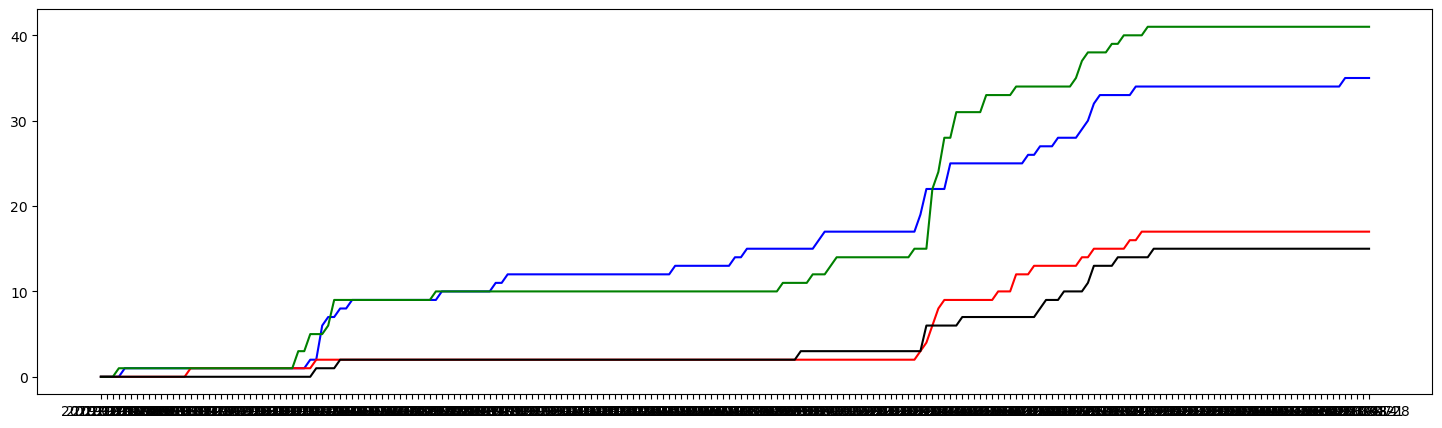

In [48]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(pd.DataFrame(grow_hit_list).set_index(trading_days) ,color='blue')
plt.plot(pd.DataFrame(fall_hit_list).set_index(trading_days),color='red' )
plt.plot(pd.DataFrame(grow_miss_list).set_index(trading_days),color='green' )
plt.plot(pd.DataFrame(fall_miss_list).set_index(trading_days),color='black' )
plt.title('')

Text(0.5, 1.0, 'Отношение hit/miss')

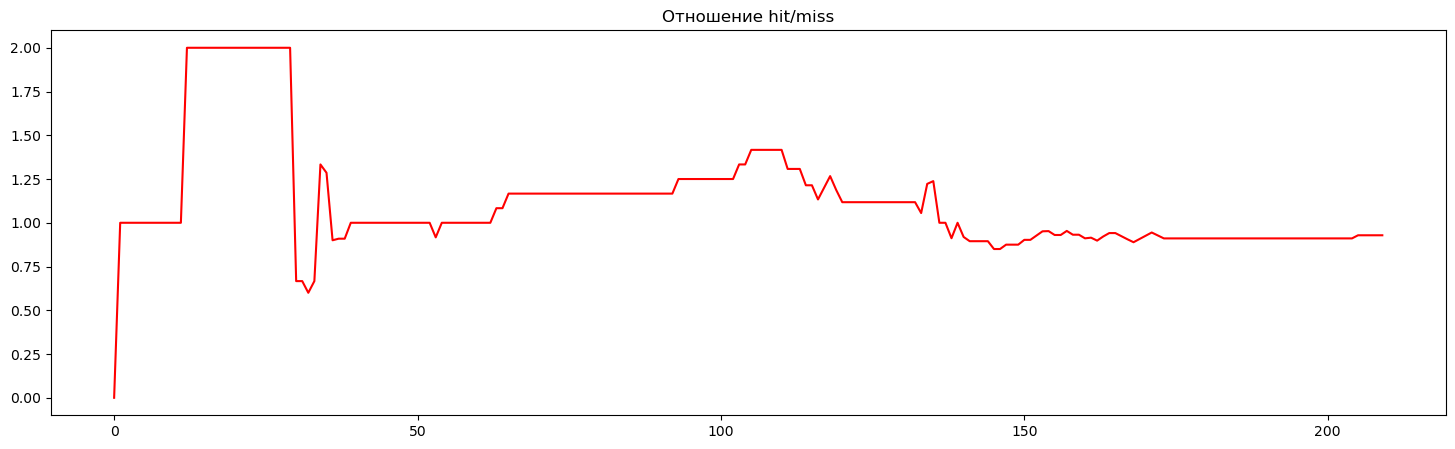

In [29]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(pd.DataFrame(fall_miss_ratio),color='red'  )
plt.title('Отношение hit/miss')

Text(0.5, 1.0, 'Общий капитал')

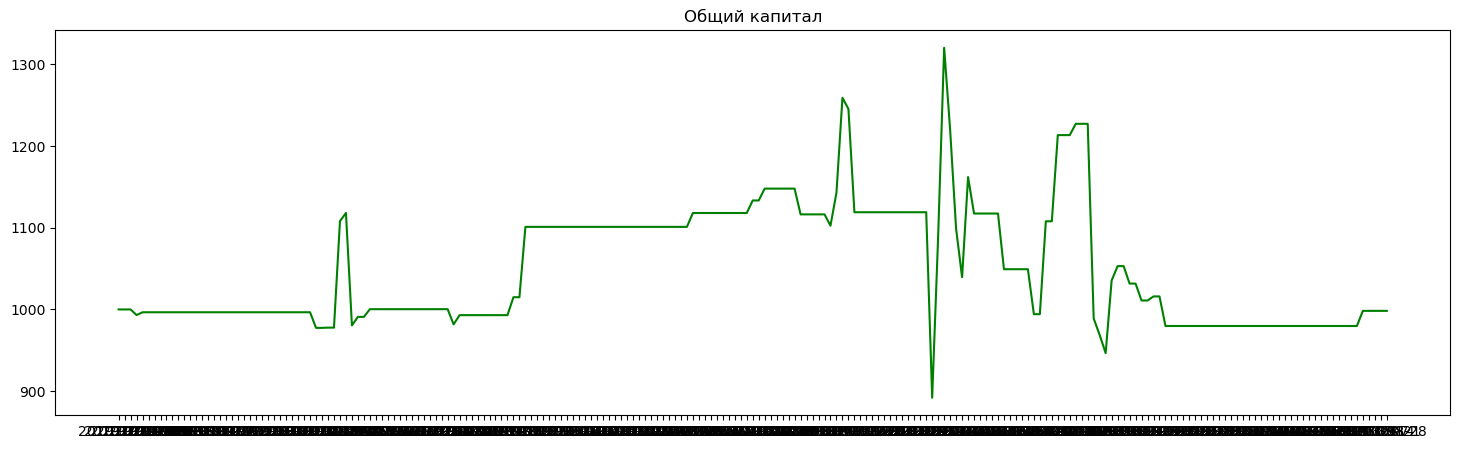

In [30]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(pd.DataFrame(capital).set_index(trading_days),color='green'  )
plt.title('Общий капитал')

# ФУНКЦИЯ ТОРГОВОГО АЛГОРИТМА

In [32]:
def trade_func(total_df , upper_bound , lower_bound):
    trading_days = total_df.index.unique() #Набор торговых дней с предсказаниями и фактами
    bank = 1000 #Сумма денег на моём счету , которые я вкладываю . Это не накопленная стоимость портфеля 
    portfolio = {} #Ключ - актив , значение - накопленный по нему доход
    grow_hit = 0 #Подсчёт попаданий на росте
    fall_hit = 0 #Подсчёт попаданий на падении
    grow_miss = 0 #Подсчёт промахов и на росте и на падении
    fall_miss = 0
    grow_hit_list = [] 
    fall_hit_list = [] 
    grow_miss_list = [] 
    fall_miss_list = []
    fall_miss_ratio = []
    capital = [] #Сумма денег в портфеле и банке которую в корце визуализирую
    coef = 0
    
    
    for day in trading_days:
        #Устанавливаем активы , которые вносим в списки потенциального роста и потенциального падения
        good_assets = total_df.loc[(total_df.prob_of_growth > upper_bound) & (total_df.index == day)].ticker.values
        bad_assets = total_df.loc[(total_df.prob_of_growth < lower_bound) & (total_df.index == day)].ticker.values
        
        #Продаём все активы перед началом торгового дня
        for asset in list(portfolio):
            bank+=portfolio[asset]
            del portfolio[asset]
    
        #Продаём активы из зоны падения и возвращаем полученные деньги в банк
        for asset in bad_assets: 
            if asset in list(portfolio):
                bank+=portfolio[asset]
                del portfolio[asset]
            #Проверяем угадали ли направление
            if 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):#1+реальная доходность
                fall_hit+=1
            elif 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
                fall_miss+=1
        
        
        #Определяем разер вложений.
        if len(good_assets) != 0:
            invest_ammout = bank/len(good_assets)#вкладываем весь банк равномерно
        else :
            invest_ammout = 0
        
        #Покупаем активы из зоны роста
        for asset in good_assets: 
            if asset not in list(portfolio): #Если его нет в портфеле ,то добавляем его
                portfolio[asset] = (invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][1])#(1+real_ret)
                bank -= invest_ammout
                #Проверка угадано ли направление доходности
                if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
                    grow_hit+=1
                elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][1]):
                    grow_miss+=1
            #elif asset in list(portfolio): #Если такой актив уже есть
                #portfolio[asset] += invest_ammout #Прибавляем к уже имеющимся вложениям а затем умножем на 1+real return
                #portfolio[asset] = portfolio[asset] * (1 + total_df.loc[total_df.ticker == asset].loc[day][0])
                #bank -= invest_ammout
                #Проверка угадано ли направление доходности
                #if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                    #grow_hit+=1
                #elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                    #miss+=1 
            
            #print(f"В актив { asset } вложил { invest_ammout } и получил {(invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][0])}")    
            
    #Пополняю списки попаданий и промахов в конце каждого дня
        grow_hit_list.append(grow_hit)
        fall_hit_list.append(fall_hit)
        grow_miss_list.append(grow_miss)
        fall_miss_list.append(fall_miss)
        if grow_miss+fall_miss != 0:
            fall_miss_ratio.append( (grow_hit+fall_hit)/(grow_miss+fall_miss) )
        capital.append( bank+(sum(portfolio[x] for x in portfolio)) )
        coef = np.mean(capital)/np.std(capital)
    #____________________ИНФОРМАЦИОННОЕ ОКНО_____________________   
        #if len(list(portfolio)) == 0 :
            #print(f"В день {day} ничего не покупалось")
        #print(f"Банк {bank}")
        #print(f"Портфель на момент {day} : {list(portfolio)}")
        #print(f"Накопленная доходность портфеля : {sum(portfolio[x] for x in portfolio)}")
        #print(f"Угаданных направлений: {grow_hit+fall_hit}")
        #print(f"Неугаданных направлений: {fall_miss+grow_miss}")
        #print('___________________________\n')
    return [capital , coef]

# Оптимизация модели по параметру E/Sigma

In [36]:
lower_bounds = np.arange(0.1, 0.4, 0.05)
upper_bounds = np.arange(0.6 , 0.9 , 0.05)
params = product(upper_bounds, lower_bounds)

In [37]:
dct = {}
for param in params : 
    res = trade_func(total_df , round(param[0],2) , round(param[1],2))
    dct[round(param[0],2),round(param[1],2)] = [res[0][-1] , res[1]]

In [38]:
dct

{(0.6, 0.1): [749.5718413541633, 3.734748663726735],
 (0.6, 0.15): [749.5718413541633, 3.734748663726735],
 (0.6, 0.2): [749.5718413541633, 3.734748663726735],
 (0.6, 0.25): [749.5718413541633, 3.734748663726735],
 (0.6, 0.3): [749.5718413541633, 3.734748663726735],
 (0.6, 0.35): [749.5718413541633, 3.734748663726735],
 (0.6, 0.4): [749.5718413541633, 3.734748663726735],
 (0.65, 0.1): [639.3037441980771, 4.949377688655057],
 (0.65, 0.15): [639.3037441980771, 4.949377688655057],
 (0.65, 0.2): [639.3037441980771, 4.949377688655057],
 (0.65, 0.25): [639.3037441980771, 4.949377688655057],
 (0.65, 0.3): [639.3037441980771, 4.949377688655057],
 (0.65, 0.35): [639.3037441980771, 4.949377688655057],
 (0.65, 0.4): [639.3037441980771, 4.949377688655057],
 (0.7, 0.1): [998.2669504077321, 14.410156834651062],
 (0.7, 0.15): [998.2669504077321, 14.410156834651062],
 (0.7, 0.2): [998.2669504077321, 14.410156834651062],
 (0.7, 0.25): [998.2669504077321, 14.410156834651062],
 (0.7, 0.3): [998.266950407